# Numerical Orbit Propagation with Scipy: ODE Solver Methods

## Extremely Brief Introduction to Numerical Orbit Propagation

Numerical propagators are indispensable tools to predict the past or future position and velocity
of an object in space. They usually bring together a detailed force model with an Ordinary
Differential Equation (ODE) Solver, solving for the position and velocity of the object sequentially
with fixed or varying timesteps.

In its simplest form, the two-body problem, the ODE to be solved is given as:

$\ddot{\vec{r}} = - \dfrac{\mu}{r^3} \vec{r}$

where $\ddot{\vec{r}}$ is the inertial acceleration, $\vec{r}$ is the position vector (with $r$ its norm).
$\mu$ is equal to the constant $GM$ (Gravitational Constant times the Mass of the main attracting body.)

## Choosing the Right Numerical Orbit Propagation Algorithm

Choosing the right numerical propagation configuration requires an understanding
of both the force model and the ODE solver matching the accuracy requirements of the application.

Usually the requirement is "for the given orbit, to have a certain level of accuracy after
a certain length of propagation duration", for example 100 m of positional accuracy after 7 days for a
near circular Low-Earth-Orbit. As can be imagined, the longer the propagation duration, the lower the accuracy.
Generally speaking, circular orbits can be modelled better than elliptic orbits. While a good force model
is also critical to maintain accuracy over longer propagation durations, for this analysis we will use a simple
two-body force model.

There are two key parameters to tune when choosing the numerical propagator configuration for the required accuracy:
1. Stepsize or error tolerance: For fixed stepsize methods, the bigger the stepsize, the lower the accuracy.
For adaptive stepsize methods, the higher the error tolerance, the lower the accuracy.
2. Degree of the numerical method: The higher the degree, the faster and/or the more accurate the propagator

And there are only two key parameters to evaluate the propagation performance:
1. Accuracy: Positional accuracy or physical quantities like conservation of energy or angular momentum
2. Speed: How long a time is required to complete the propagation run

## How to Measure Accuracy

Before going any further, the concept of accuracy should be elaborated in some more detail.
As a general rule, a numerical propagator is never exact and always has some error. In the case of two-body dynamics,
there are exact analytical propagators for verification. But we will use the physical properties of the problem to
estimate the error. The two-body problem has the property of conservation of energy, where the specific energy
is given as:

$\varepsilon = \dfrac{v^2}{2} - \dfrac{\mu}{r}$

with $v$ is the norm of the velocity vector, $r$ is the norm of the position vector
and $\mu$ is equal to the constant $GM$ (Gravitational Constant times the Mass of
the main attracting body). This is the formula for the specific energy, or the sum of
potential and kinetic energy *per unit mass*.

Therefore, in theory, a solution that conserves the energy throughout the propagated orbit will mean
no errors (apart from time errors that are exhibited by some numerical propagation algorithms and
numerical errors due to machine precision). Therefore, a solution that has a zero mean energy
variation will at least conserve the energy *on average* and will not exhibit a drift from the true trajectory,
though there will be local errors in position and velocity.
If the energy has a fixed offset against the initial value, it can be shown that the solution drifts away from
the true state (position and velocity) linearly. Similarly, a linear decrease in energy will be similar to drag
and will mean that the
satellite is losing altitude (which is not realistic for a periodic problem like the two-body problem) and the
propagated trajectory will drift away from the true state *quadratically*. Therefore, how well the energy is
conserved is a direct measure of accuracy.

## Scipy ODE Solvers as Numerical Orbit Propagation Engines

After this lengthy (but necessary) introduction, we can start the analysis.
We will use the existing [ODE solvers in Scipy](https://docs.scipy.org/doc/scipy/reference/integrate.html),
testing their accuracy and runtimes with respect to each other with the same initial conditions and same
error tolerance.

In [23]:
from satmad.propagation.sgp4_propagator import SGP4Propagator
from satmad.propagation.tle import TLE

name = "RASAT"
line1 = "1 37791U 11044D   18198.20691930 -.00000011  00000-0  70120-5 0  9992"
line2 = "2 37791  98.1275 290.4108 0021116 321.0704  38.8990 14.64672859369594"

tle = TLE.from_tle(line1, line2, name)

rv_init = SGP4Propagator().propagate(tle, tle.epoch)

In this analysis we will demonstrate the steps to analyse the performance of a numerical
propagator. The setup is a satellite in near circular, Low-Earth-Orbit (LEO), initialised with a TLE for convenience.
The first step is to extract the "initial state", or position and velocity at a given time.

In [24]:
from astropy import units as u
from satmad.propagation.numerical_propagators import ODESolverType

stepsize = 120 * u.s
solver_types = [solver_type for solver_type in ODESolverType]

rtol = 3e-10
atol = 1e-11
init_time_offset = 0 * u.day
duration = 1.0 * u.day

For this example, the absolute tolerance is set to `3e-11` and the relative tolerance is set to
`1e-11`. These are rather low values, forcing the adaptive timestep ODE solvers to smaller steps,
with higher accuracy but longer run times. The total run duration is one day, which is enough to see
how the energy behaves during the propagation. The output stepsize is 120 seconds. Note that each of these
algorithms feature interpolators to yield results at the requested stepsize - therefore, the accuracy of this
interpolator is a determinant of the final accuracy assessment.

In [27]:
from satmad.propagation.tests.num_prop_analysis.num_prop_analysis_engine import analyse_energy_along_trajectory

cases = {}
type(cases)

# run all cases
for solver_type in solver_types:
    name = solver_type.value

    analyse_energy_along_trajectory(
        cases,
        name,
        rv_init,
        stepsize,
        solver_type,
        init_time_offset,
        duration,
        rtol,
        atol,
    )

**** Case: RK45 ****
Runtime: 0.4731 s seconds
max energy diff: 1.8837382853575946e-07
mean energy    : 9.369180701294752e-08
init mean energy diff : 1.2526983184102391e-08
final mean energy diff: 1.7486814840594889e-07
**** Case: RK23 ****
Runtime: 6.8755 s seconds
max energy diff: 2.5065629571940917e-07
mean energy    : 1.2520529591502944e-07
init mean energy diff : 1.7360403852251237e-08
final mean energy diff: 2.3305738022116885e-07
**** Case: DOP853 ****
Runtime: 0.1602 s seconds
max energy diff: 2.0369061104474895e-08
mean energy    : -9.157697549884519e-10
init mean energy diff : 1.623300391884186e-09
final mean energy diff: -3.475060417201803e-09
**** Case: Radau ****
Runtime: 3.3699 s seconds
max energy diff: 3.085375510636368e-09
mean energy    : -2.1433359510084098e-10
init mean energy diff : -2.960163669740723e-11
final mean energy diff: -3.9437118459773045e-10
**** Case: BDF ****
Runtime: 0.9815 s seconds
max energy diff: 1.9196197634130385e-05
mean energy    : -9.56483442

The next step (`analyse_energy_along_trajectory()`) propagates the trajectory with each of the solver types
for this given configuration and then computes the energy difference with respect to the energy of the
initial state. The method also keeps the runtime duration of the propagator to output it later.

Some conclusions can already be drawn from the printed results, but we will plot them to see the behaviour
more clearly.

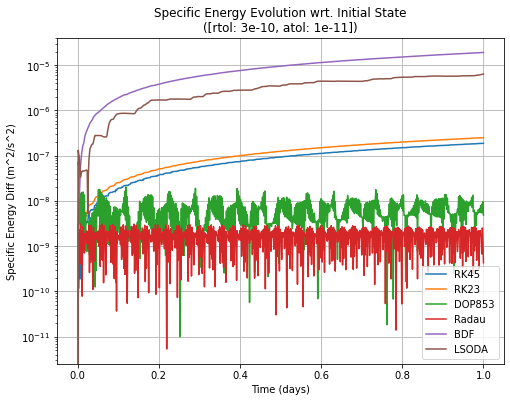

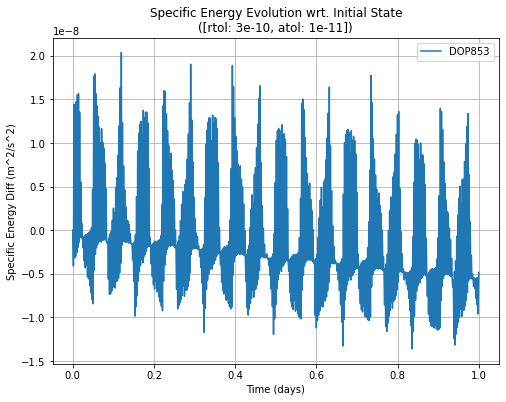

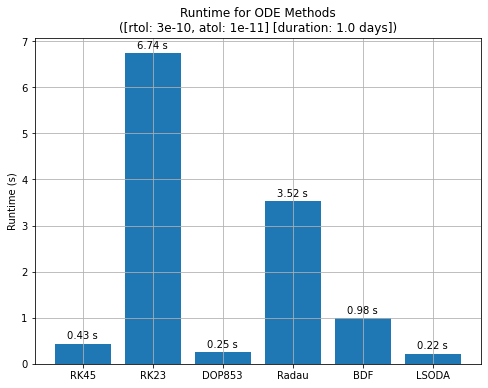

In [26]:
from satmad.propagation.tests.num_prop_analysis.num_prop_analysis_engine import plot_energy_diff, plot_runtimes

session_name = f"[rtol: {rtol}, atol: {atol}]"

# Plot energy differences
plot_energy_diff(cases, title=session_name, logscale_plot=True)

# Plot DOP853 on linear scale to see its behaviour
plot_energy_diff(
    {"DOP853": cases["DOP853"]}, title=session_name, logscale_plot=False
)

# Plot runtimes
plot_runtimes(
    cases, title=f"{session_name} [duration: {duration.to_value(u.day)} days]", logscale_plot=False
)

The first plot ("Specific Energy Evolution") shows the evolution of the specific energy with respect to the initial
specific energy on log scale. Clearly, BDF and LSODA are the worst of the bunch, showing the largest deviations in energy.
While not evident from the log plot, they exhibit a clear linear growth in energy (though in absolute value for correct
log plotting). Assuming the energy growth is really in the positive direction, this means an increase in energy with
the orbit spiralling out and away from the central body - this is obviously not in accordance with the physical reality.
The next two are the RK23 and RK45 adaptive Runge-Kutta algorithms, generally with similar behaviour and energy conservation
properties.  The lowest variation in energy are demonstrated by DOP853 and Radau algorithms. Purely from an accuracy
perspective for a given error tolerance, the best algorithms are DOP853 and Radau.

The second plot is the same as the first one, but on a linear scale and showing the evolution of the specific energy
for the DOP853 case only. There are two distinct behaviours, the first is a periodic variation along the orbit and the
second is a linear decrease in energy (in the previous plot, absolute values were shown in log scale). This linear
decrease in energy would mean that the satellite was *leaking* energy, in effect acting like a drag, forcing the satellite
towards the earth in a slowly spiral. Obviously, this is a numerical artifact from the ODE solver algorithms. In fact,
most popular ODE solvers do not respect the physical properties like conservation of energy and are not suited well
for very long term propagation due to this linear departure of energy from the true value. Instead,
[Symplectic Integrators](https://en.wikipedia.org/wiki/Symplectic_integrator) are used for these problems.

The final plot shows the runtimes for each ODE Solver. The ones with worst energy conservation properties, LSODA and BDF
are reasonably good performers on the runtime front. The second tier in energy was RK23 and RK45.
Clearly, the lower degree RK23 struggled to keep the energy error low, resulting in significantly longer runtimes.
The higher degree RK45 is more efficient, combining middling energy conservation performance with a good runtime
performance - this explains why RK45 is the standard integrator for student projects and prototype algorithms (and
also why it is almost never the choice for the final software product). Finally, the best performers in energy, DOP853
and Radau algorithms yield distinctly different results in runtime. Clearly DOP853 is the most efficient of all the algorithms
for this problem, combining very good accuracy with excellent runtime performance. This is because of the high degree
numerical propagation method and with the good interpolation algorithm under the hood to yield the results at the requested
timestep.

To summarise, we have analysed how we can choose the numerical propagation (or ODE Solver) algorithm
for the two-body problem, in a near circular, Low-Earth-Orbit setting and we have shown that DOP853
is the best choice from accuracy and runtime performance point of view. In the
[second installment](https://github.com/egemenimre/satmad/tree/master/docs/_build/html/examples/analysis/num_prop_performance_2.html)
of this series we will look closer to the performance of DOP853 for various error tolerance
values.

The `main` for this analysis is
[here in Github](https://github.com/egemenimre/satmad/blob/master/satmad/propagation/tests/num_prop_analysis/num_prop_analysis_energy.py)
for you to play with the results and change the analysis cases.